__Liudmila Semenova  
UDACITY Data Analyst Nanodegree Program  
2019, April 16__

# Analyze A/B Test Results


# Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)


<a id='intro'></a>
## Introduction

The main goal of this project is to analyze whether the company, which has developed a new web page in order to increase the number of users who "convert", should implement this new page or keep the old page. The methods which were used to solve this problem are A/B Test and regression analyses.  

The main dataset is `ab_data.csv` which contains information about the two groups of users, the types of page they have visited, and whether the pages have been "converted" or not.

The additional dataset is `countries.csv` which contains information what countries users are from. These data should help to analyze whether the conversion rate were effected by user's country or not. 

<a id='probability'></a>
### Part I - Probability

In [2]:
# import libraries 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt
%matplotlib inline

# set the seed 
random.seed(42)

__`1.`__ Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

__`a.`__ Read in the dataset and take a look at the top few rows here:

In [3]:
# read the dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


__`b.`__ Use the below cell to find the number of rows in the dataset.

In [4]:
# get the number of rows in the dataset
df.shape[0]

294478

__`c.`__ The number of unique users in the dataset.

In [5]:
# get the number of unique users in the dataset
df.user_id.nunique()

290584

__`d.`__ The proportion of users converted.

In [6]:
# calculate the proportion of users converted
df.query('converted == 1').user_id.nunique()/df.user_id.nunique()*100

12.104245244060237

__`e.`__ The number of times the `new_page` and `treatment` don't line up.

In [7]:
# calculate the number of times the new_page and treatment do not line up
df.query('(group == "treatment" or landing_page == "new_page")\
and (group != "treatment" or landing_page != "new_page")').count()[0]

3893

__`f.`__ Do any of the rows have missing values?

In [8]:
# check the missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

__`2.`__ For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

__`a.`__ Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# create a new dataset with only rows where group and landing_page match
df2 = df.query('(group == "treatment" and landing_page == "new_page")\
or (group == "control" and landing_page == "old_page")')

In [10]:
# double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

__`3.`__ Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

__`a.`__ How many unique **user_id**s are in **df2**?

In [11]:
# get the number of unique user_ids in df2
df2.user_id.nunique()

290584

__`b.`__ There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# get user_id of duplicated users
df2[df2.user_id.duplicated(keep=False)].user_id.iloc[0]

773192

__`c.`__ What is the row information for the repeat **user_id**? 

In [13]:
# get all rows with the duplicated user
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


__`d.`__ Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# drop the second row with the duplicated user
df2 = df2.drop_duplicates(subset='user_id', keep='first', inplace=False)

__`4.`__ Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

__`a.`__ What is the probability of an individual converting regardless of the page they receive?

In [15]:
# calculate the probability of an individual converting regardless of the page they receive
print('{:.4}'.format(df2.converted.mean()))

0.1196


__`b.`__ Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
# calcalute the probability of an individual converting if they are in the control group
control_converted = df2.query('group == "control"')['converted'].mean()
print('{:.4}'.format(control_converted))

0.1204


__`c.`__ Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
# calculate the probability of an individual converting if they are in the treatment group
treatment_converted = df2.query('group == "treatment"')['converted'].mean()
print('{:.4}'.format(treatment_converted))

0.1188


__`d.`__ What is the probability that an individual received the new page?

In [18]:
# calculate the probability that an individual received the new page
print('{:.4}'.format((df2.query('landing_page == "new_page"').count()/df2.shape[0])[0]))

0.5001


In [19]:
# calculate the difference beetwen the probability of an individual converting from the treatment group
# and the probability of an individual converting from the control group
diff = treatment_converted - control_converted
diff

-0.0015782389853555567

__`e.`__ Consider your results from __`a.`__ through __`d.`__ above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

__ANSWER__

__The obtained results show the following:__

- __the conversation rate for an individual from the contol group who received the old page is 12.04%;__ 
- __the conversation rate for an individual from the treatment group who received the new page is 11.88%;__ 
- __probability that an individual received the new page is 0.5001 which means that the control and treatment groups are almost equal.__ 

__Based on all information we can conclude that the conversation rate for the old page is slightly greater than for the new page. Therefore, there is not any sufficient evidence to say that the new page leads to more conversions. However, the difference between these two conversation rates is small enough to consider it significant, so further research is needed.__

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


__`1.`__ For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**ANSWER**

$$H_0: p_{new} - p_{old} \leq 0 $$ 
$$H_1: p_{new} - p_{old} > 0 $$ 

__`2.`__ Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

__`a.`__ What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
# calculate the probability of an individual converting received the new page under the null hypothesis
p_new = df2.converted.mean()
p_new

0.11959708724499628

__`b.`__ What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
# calculate the probability of an individual converting received the old page under the null hypothesis
p_old = df2.converted.mean()
p_old

0.11959708724499628

__`c.`__ What is $n_{new}$?

In [21]:
# calculate the number of people who received the new page
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new

145310

__`d.`__ What is $n_{old}$?

In [22]:
# calculate the number of people who received the old page
n_old = df2.query('landing_page == "old_page"').count()[0]
n_old

145274

__`e.`__ Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [47]:
# generate a random sample with n_old transactions and a convert rate of p_new
new_page_converted = np.random.choice([0,1],n_new, p=[p_new,1-p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

__`f.`__ Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [48]:
# generate a random sample with n_old transactions and a convert rate of p_old
old_page_converted = np.random.choice([0,1],n_old, p=[p_old,1-p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

__`g.`__ Find $p_{new}$ - $p_{old}$ for your simulated values from part __`e`__ and __`f`__.

In [49]:
# calculate the difference between the probability of an individual converting received new page and 
# the probability of an individual converting received old page under the null hypothesis
print('{:.4}'.format(new_page_converted.mean() - old_page_converted.mean()))

0.001654


__`h.`__ Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **`a.` through `g.`** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [50]:
# simulate 10,000 samples of the difference from part g.
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1],n_new, p=[p_new,1-p_new])
    old_page_converted = np.random.choice([0,1],n_old, p=[p_old,1-p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

__`i.`__ Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

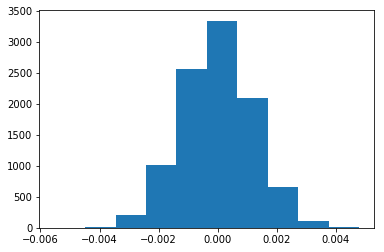

In [51]:
# plot histogram of the 10,000 differences from part h.
plt.hist(p_diffs);

__`j.`__ What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [52]:
# calculate proportion of the p_diffs are greater than actual difference diff calculating in Part I - Probability
(p_diffs > diff).mean()

0.9052

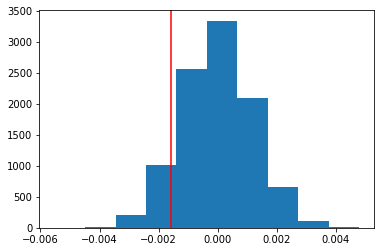

In [53]:
# draw a line actual difference on the histogram from part i
plt.hist(p_diffs);
plt.axvline(x=diff, color="red");

__`k.`__ In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**ANSWER**

__1. The value we computed in this part is p-value, the probability of observing the statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.__

__2. The computed p-value is large (0.9052 > 0.05) that indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis. Since our null hypothesis suggest that the probability of an individual converting received the new page is less or equal the probability of an individual converting received the ond page, we can conclude that the new page does not leads to more conversions.__

__`l.`__ We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [54]:
# calculate the number of conversions for each page and the number of individuals who received each page
convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

__`m.`__ Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [66]:
# calculate z-score and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print('z-score = {:.5}'.format(z_score))
print('p-value = {:.3}'.format(p_value))

z-score = -1.3109
p-value = 0.905


__`n.`__ What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**ANSWER**

- __in a left-tailed Z-test with $\alpha$ = 0.05 the critical value is Z = 1.645 which is greater than the z-score = -1.3109 so we fail to reject the null hypothesis;__

- __in addition the p-value = 0.905 is the same that we computed in part j and it is also greater than 0.05.__

__These findings are consistent with our findings in the part k: the new page does not leads to more conversions.__

<a id='regression'></a>
### Part III - A regression approach

__`1.`__ In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

__`a.`__ Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**ANSWER**

__Logistic regression.__

__`b.`__ The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [20]:
# create a new dataset
df3 = df2.copy()
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [21]:
# add intercept, non_ab_page and ab_page columns 
df3['intercept'] = 1
df3[['non_ab_page', 'ab_page']] = pd.get_dummies(df3['group'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,non_ab_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


__`c.`__ Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [22]:
# fit regression model and obtain the results
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


__`d.`__ Provide the summary of your model below, and use it as necessary to answer the following questions.

In [23]:
# show the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        01:14:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

__`e.`__ What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**ANSWER**

__The p-value associated with ab_page is 0.19 and it is greater than $\alpha$ = 0.05 so we we fail to reject the null hypothesis.__


__P-value that we found in the Part III is less than p-values in the Part II - 0.9052 and 0.905. This difference can be explained by difference between hypotheses which we explore in the Part II and the Part III. In the Part II we tried to find out if the new page is better than the old page in terms of conversion rate so we use one-tailed test. And in Part III we explore whether there is a conversion or not which means that our null and alternative hypotheses are:__

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} \neq 0$$

__So in Part III we used two-tailed test. Since we know that p-value for left-tailed hypothesis is 1 - 0.5 x (two-tailed p-value) we  can  calculate the next: 1 - 0.5 x 0.19 = 0.905 which confirm results from Part II.__

__`f.`__ Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**ANSWER**

__There might be many factors that we can consider influencing the result of whether or not an individual conversions: users demographic like age, gender, location, education, level of income, etc, website performance and adaptability, whether the user is new or returning, duration of the experiment, and even at what time of day and on what day of week the user received the page.__

__However, even we add relevant variables which can obviously prevent bias in the estimate of the other regression coefficient there are some disadvantages to adding additional terms into a regression model:__

- __multicollinearity - when we have predictor variables that are correlated with one another;__
- __Simpson's paradox - when groups of data show one particular trend, but this trend is reversed when the groups are combined together;__
- __correlated errors - when adding data correlate with each other (from one time and/or one space) .__


__`g.`__ Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [24]:
# creatig countries_df dataset from countries.csv
countries_df = pd.read_csv('./countries.csv')

# merging together countries_df and df3
df4 = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df4.head()

,country,timestamp,group,landing_page,converted,intercept,non_ab_page,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [25]:
# getting all unique values from the country column
df4.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [26]:
# create the necessary dummy variables
df4[['UK', 'US', 'CA']] = pd.get_dummies(df4['country'])
df4.head()

,country,timestamp,group,landing_page,converted,intercept,non_ab_page,ab_page,UK,US,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [27]:
# using regression model and getting results
log_mod = sm.Logit(df4['converted'], df4[['intercept', 'US', 'CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 01 Jun 2019   Pseudo R-squ.:               1.521e-05
Time:                        01:14:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0507      0.028      1.786      0.074      -0.005       0.106
CA             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**ANSWER**

__Since p-values associated with countries are greater then $\alpha$ = 0.05 we can not conclude that the countries where users live have an impact on conversion.__

__`h.`__ Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [28]:
# create new columns which are interaction between page and countries
df4['UK & ab_page'] = df4['ab_page']*df4['UK']
df4['US & ab_page'] = df4['ab_page']*df4['US']
df4['CA & ab_page'] = df4['ab_page']*df4['CA']
df4.head()

,country,timestamp,group,landing_page,converted,intercept,non_ab_page,ab_page,UK,US,CA,UK & ab_page,US & ab_page,CA & ab_page
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1,0


In [29]:
# fit regression model and obtain the results
log_mod = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'US', 'CA', 'US & ab_page', 'CA & ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 01 Jun 2019   Pseudo R-squ.:               3.482e-05
Time:                        01:14:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page         -0.0674      0.052     -1.297      0.195      -0.169       0.034
US               0.0118      0.040      0.296      0.767      -0.066       0.090
CA               0.0175      0.038      0.465      0.642      -0.056       0.091
US & ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
CA & ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
================================================================================
"""

**ANSWER**

__Since p-values associated with interactions between a page and a country are greater then $\alpha$ = 0.05 we can not conclude that they effect on conversion.__

<a id='conclusions'></a>
## Conclusions

In this project, we analyzed whether the company, which has developed a new web page in order to increase the number of users who "convert", should implement this new page or keep the old page. 

In Part I, we calculated probabilities of an individual converting if they received the new page and if they received the old page, then compared these probabilities with each other. Although the old page leads to more conversions, the difference was extremely small.

In Part II, we conducted A/B test: stated null and alternative hypotheses and then manually computed p-value in order to find evidence against the null hypothesis. Then we calculated z-score and p-value using a built-in module of Python library. Both p-values were greater than $\alpha$ = 0.05 and z-score was less than the critical value. 

In Part III, we used logistic regression to analyze our null and alternative hypotheses and test whether the countries in which users live had an impact on the conversation rate. P-values for countries and an interaction between the page and countries were greater than $\alpha$ = 0.05. 

All results we have obtained show that there are no reasons to implement the new page since it did not lead to more conversions. 

## Resources
http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTest-Means-Proportions/BS704_HypothesisTest-Means-Proportions3.html  
https://github.com/statsmodels/statsmodels/issues/4263  
https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html  
https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html  
http://datascientist.one/p-value/  